In [1]:
# SISO 5G gNB-UE Simulation using AIRSTRAN D 2200
import os

# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

# Other imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mitsuba as mi
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", message="invalid value encountered in multiply")
warnings.filterwarnings("ignore", category=UserWarning, module="jupyter_client")

# Import relevant components from Sionna RT
from sionna.rt import load_scene, Transmitter, Receiver, Transmitter, Camera, PathSolver
from sionna.rt import AntennaArray, PlanarArray, SceneObject, ITURadioMaterial
from sionna.rt.antenna_pattern import antenna_pattern_registry

scene_xml_path = "../scene/scenes/Duke/scene.xml"
# Load empty scene
scene = load_scene(scene_xml_path)
# Set the operating frequency (n48 band for 5G)

2026-02-12 04:59:28 WARN  [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).


In [2]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath('../src'))

In [3]:
# Install plyfile if not available
try:
    from plyfile import PlyData
except ImportError:
    import os
    os.system("pip install plyfile")
    from plyfile import PlyData

In [4]:
# ============================================
# SISO Configuration: gNB to UE
# ============================================

scene.frequency = 5.0e9  # 3.7 GHz

# Define UE position (fixed to start)
ue_position = [10.0, 0.0, 0.0]   # UE position (x, y, z in meters)

# ============================================
# Antenna Configuration
# ============================================

# gNB antenna: 3GPP TR 38.901 pattern (AIRSTRAN D 2200)
gnb_pattern_factory = antenna_pattern_registry.get("tr38901")
gnb_pattern = gnb_pattern_factory(polarization="V")

# UE antenna: Isotropic pattern (typical for mobile devices)
# This will be required for matching the calculations of the RadioMapSolver()
ue_pattern_factory = antenna_pattern_registry.get("iso")
# Polarization should also match the transmitter
ue_pattern = ue_pattern_factory(polarization="V")

# SISO: Single antenna element at origin [0, 0, 0] for both TX and RX
single_element = np.array([[0.0, 0.0, 0.0]])  # Shape: (1, 3)

# Configure antenna arrays
scene.tx_array = AntennaArray(
    antenna_pattern=gnb_pattern,
    normalized_positions=single_element.T  # Shape: (3, 1)
)

scene.rx_array = AntennaArray(
    antenna_pattern=ue_pattern,
    normalized_positions=single_element.T  # Shape: (3, 1)
)

# ============================================
# Add Receiver to Scene
# ============================================

# Create UE receiver
rx = Receiver(name="ue", position=ue_position, display_radius=0.03)
scene.add(rx)

# ============================================
# Configure Propagation Environment
# ============================================

# Disable scattering for basic simulation
for radio_material in scene.radio_materials.values():
    radio_material.scattering_coefficient = 0.4

Available buildings in scene: 154 total

Building 5:
  Rooftop height: 10.50 m
  X range: [-359.61, -268.82] m (center: -314.22)
  Y range: [85.82, 166.54] m (center: 126.18)
  Vertices: 23

Building 6:
  Rooftop height: 21.00 m
  X range: [108.98, 261.57] m (center: 185.27)
  Y range: [378.62, 491.15] m (center: 434.89)
  Vertices: 42

Building 7:
  Rooftop height: 17.50 m
  X range: [357.85, 476.71] m (center: 417.28)
  Y range: [316.22, 444.32] m (center: 380.27)
  Vertices: 11

Building 8:
  Rooftop height: 17.50 m
  X range: [298.98, 371.08] m (center: 335.03)
  Y range: [432.44, 520.85] m (center: 476.65)
  Vertices: 18

Building 9:
  Rooftop height: 17.50 m
  X range: [-316.06, -228.78] m (center: -272.42)
  Y range: [-109.71, -16.41] m (center: -63.06)
  Vertices: 6

Building 10:
  Rooftop height: 17.50 m
  X range: [185.39, 260.42] m (center: 222.91)
  Y range: [581.46, 634.82] m (center: 608.14)
  Vertices: 14

Building 11:
  Rooftop height: 10.50 m
  X range: [51.31, 115.30]

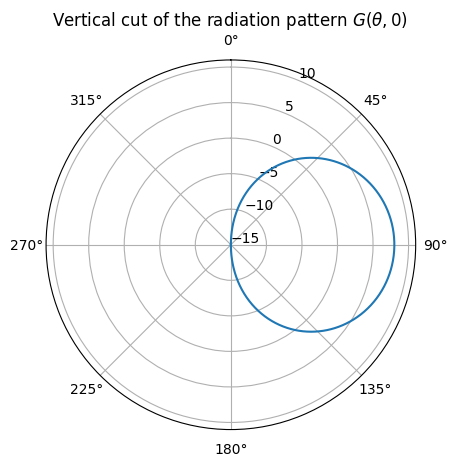

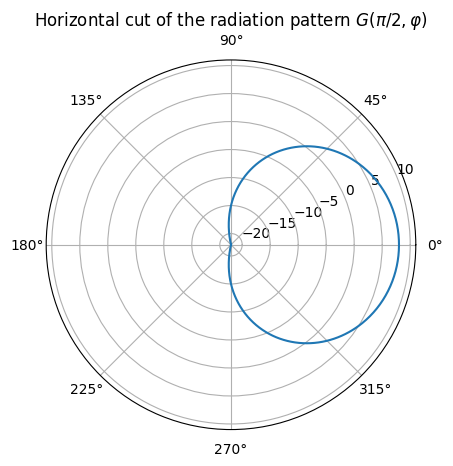

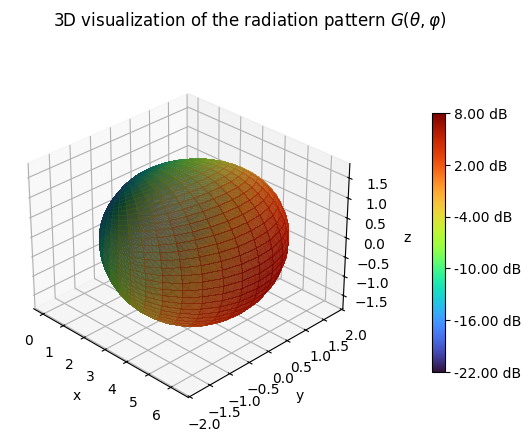

In [5]:
from scene_parser import extract_building_info
from tx_placement import TxPlacement
# ============================================
# Place gNB on a Specific Building
# ============================================

building_info = extract_building_info(scene_xml_path, verbose=True)

# Old: 46
selected_building_id = 37  # Change this to your desired building number

# TxPlacement will create the transmitter if it doesn't exist and place it on the building
# Correct parameter order: (scene, tx_name, scene_xml_path, building_id, offset)
tx_placer = TxPlacement(scene, "gnb", scene_xml_path, selected_building_id, offset=2.0)
tx_placer.set_rooftop_center()

# Get reference to the transmitter (already added to scene by TxPlacement)
tx = tx_placer.tx
# Convert to flat numpy array instead of nested list
gnb_position = tx.position.numpy().flatten().tolist()

# Point antenna toward UE
tx.look_at(ue_position)

print(f"\nSuccess! gNB placed on building {selected_building_id}")
print(f"Position: {gnb_position}")

# ============================================
# Compute Propagation Paths
# ============================================

# Instantiate path solver
p_solver = PathSolver()

# Compute propagation paths
paths = p_solver(
    scene=scene,
    max_depth=5,
    los=True,
    specular_reflection=True,
    diffuse_reflection=False,
    refraction=False,
    seed=41
)

# ============================================
# Visualize Scene
# ============================================

# Setup camera
cam = Camera(position=(100.0, 100.0, 50.0))
cam.look_at(gnb_position)

# Preview the scene with propagation paths
scene.preview(
    paths=paths,
    resolution=[1000, 1000],
    clip_at=200,
    show_orientations=True
)

gnb_pattern.show();

Zone contains 45131 grid cells
Zone coverage: 2.3% of map
Naive baseline look-at: [0.0, 200.0, 0.0]
Zone centroid: [0.2969688240898717, 212.02416299217833]



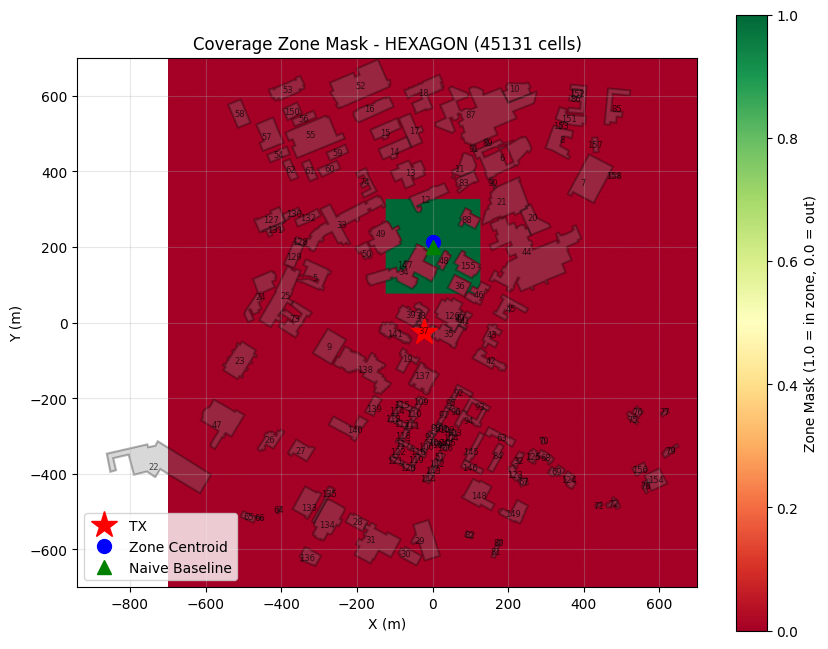

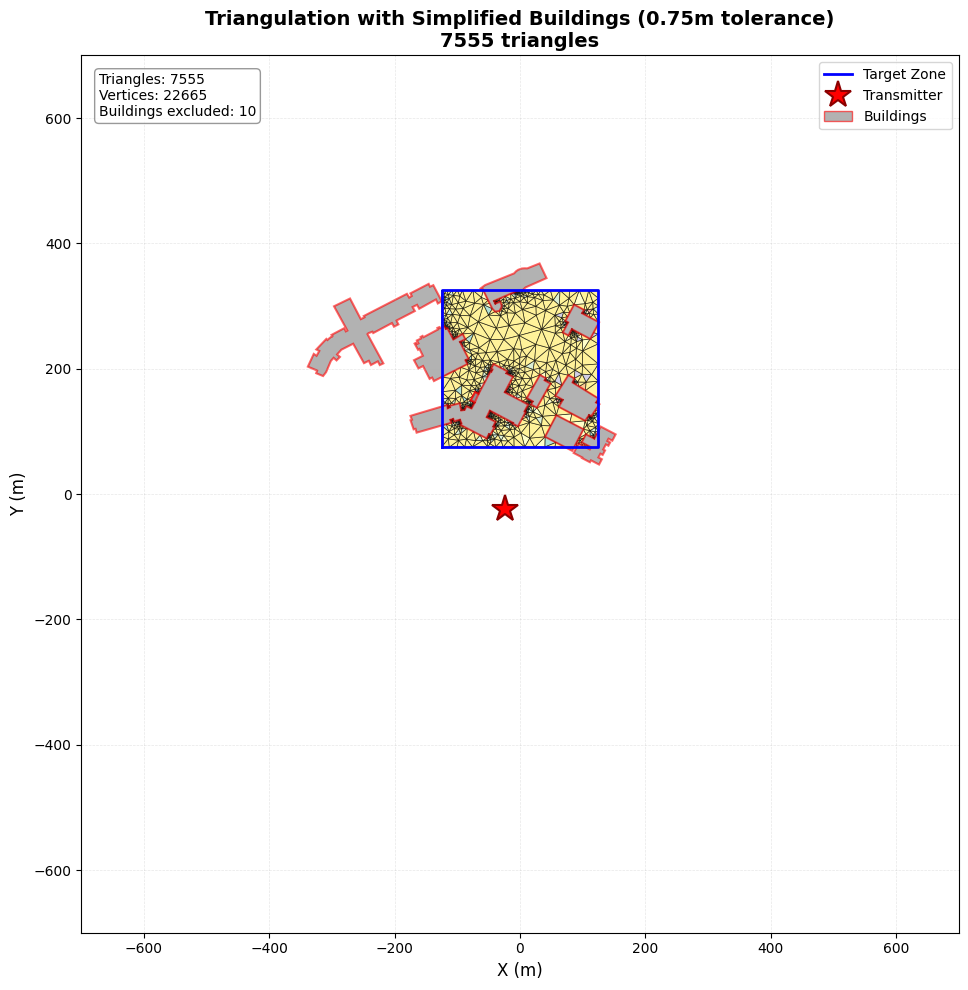

In [6]:
from boresight_pathsolver import (
    optimize_boresight_pathsolver,
    create_zone_mask
)
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MPLPolygon
import numpy as np
import scipy
import scipy.stats.qmc as qmc

# Define the map configuration
map_config = {
    'center': [0.0, 0.0, 0.0],
    'size': [1400, 1400],
    'cell_size': (1.0, 1.0),
    'ground_height': 0.0,
}

# Hexagon vertices centered at [0, -200] with radius ~307
hexagon_vertices = [
    (0, 107),       # Top
    (266, -47),     # Top-right
    (266, -353),    # Bottom-right
    (0, -507),      # Bottom
    (-266, -353),   # Bottom-left
    (-266, -47)     # Top-left
]

# Complex irregular "splat" polygon centered at [-400.0, -150.0]
# More vertices for a smoother, more organic paint-splat shape
splat_vertices = [
    (-400.0 + 120.0, -150.0 + 140.0),   # Top protrusion peak
    (-400.0 + 95.0,  -150.0 + 110.0),   # Top protrusion right slope
    (-400.0 + 80.0,  -150.0 + 85.0),    # Top-right shoulder
    (-400.0 + 115.0, -150.0 + 65.0),    # Right bulge start
    (-400.0 + 160.0, -150.0 + 40.0),    # Right protrusion peak
    (-400.0 + 140.0, -150.0 + 10.0),    # Right protrusion lower
    (-400.0 + 90.0,  -150.0 - 20.0),    # Right side indent
    (-400.0 + 110.0, -150.0 - 55.0),    # Right lower bulge
    (-400.0 + 130.0, -150.0 - 110.0),   # Bottom-right protrusion
    (-400.0 + 85.0,  -150.0 - 130.0),   # Bottom-right slope
    (-400.0 + 20.0,  -150.0 - 150.0),   # Bottom protrusion peak
    (-400.0 - 35.0,  -150.0 - 145.0),   # Bottom center
    (-400.0 - 100.0, -150.0 - 120.0),   # Bottom-left slope
    (-400.0 - 135.0, -150.0 - 75.0),    # Left lower bulge
    (-400.0 - 150.0, -150.0 - 30.0),    # Left protrusion peak
    (-400.0 - 140.0, -150.0 + 10.0),    # Left protrusion upper
    (-400.0 - 110.0, -150.0 + 60.0),    # Left side upper
    (-400.0 - 70.0,  -150.0 + 90.0),    # Left-top bulge
    (-400.0 - 30.0,  -150.0 + 120.0),   # Top-left protrusion
    (-400.0 + 20.0,  -150.0 + 125.0),   # Top-left slope
]

# Use polygon format for zone_params (consistent across all functions)
zone_params = {
    'vertices': splat_vertices
}

zone_params = {
    'center': [0.0, 200.00],
    'width': 250,
    'height': 250
}

# Define the zone configuration using POLYGON instead of BOX
zone_mask, naive_look_at, zone_stats = create_zone_mask(
    map_config=map_config,
    zone_type='box',  # Changed from 'box' to 'polygon'
    origin_point=gnb_position,
    zone_params=zone_params,
    target_height=0.0,
    scene_xml_path=scene_xml_path,
    exclude_buildings=True
)
print(f"Zone contains {zone_stats['num_cells']} grid cells")
print(f"Zone coverage: {zone_stats['coverage_fraction']*100:.1f}% of map")
print(f"Naive baseline look-at: {zone_stats['look_at_xyz']}")
print(f"Zone centroid: {zone_stats['centroid_xy']}")
print()

# Visualize the Zone Mask
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(
    zone_mask,
    origin='lower',
    cmap='RdYlGn',
    extent=[
        map_config['center'][0] - map_config['size'][0]/2,
        map_config['center'][0] + map_config['size'][0]/2,
        map_config['center'][1] - map_config['size'][1]/2,
        map_config['center'][1] + map_config['size'][1]/2,
    ],
    vmin=0,
    vmax=1
)
plt.colorbar(im, ax=ax, label='Zone Mask (1.0 = in zone, 0.0 = out)')

# Add building polygons and labels
for building_id, bldg_data in building_info.items():
    # Extract XY coordinates (ignore Z for 2D plot)
    vertices_2d = bldg_data['vertices'][:, :2]  # Only take x, y columns

    # Create polygon patch with gray fill
    polygon = MPLPolygon(vertices_2d, closed=True, fill=True,
                         facecolor='gray', edgecolor='black', 
                         linewidth=1.5, alpha=0.3)
    ax.add_patch(polygon)

    # Calculate true centroid from vertices (not bounding box center)
    centroid_x = np.mean(vertices_2d[:, 0])
    centroid_y = np.mean(vertices_2d[:, 1])
    
    # Add building ID label at centroid
    ax.text(centroid_x, centroid_y, str(building_id),
            fontsize=6, fontweight='normal', ha='center', va='center',
            color='black', alpha=0.7)

ax.plot(gnb_position[0], gnb_position[1], 'r*', markersize=20, label='TX')
ax.plot(zone_stats['centroid_xy'][0], zone_stats['centroid_xy'][1], 'bo',
        markersize=10, label='Zone Centroid')
ax.plot(zone_stats['look_at_xyz'][0], zone_stats['look_at_xyz'][1], 'g^',
        markersize=10, label='Naive Baseline')
ax.set_title(f'Coverage Zone Mask - HEXAGON ({zone_stats["num_cells"]} cells)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

from triangulate import get_zone_polygon_with_exclusions, triangulate_zone, visualize_triangulation, diagnose_polygon_issues, sample_triangulated_zone

# Step 1: Get the polygon with building exclusions
target_zone, building_exclusions, zone_polygon = get_zone_polygon_with_exclusions(
    zone_type='box',
    zone_params=zone_params,
    scene_xml_path=scene_xml_path,
    exclude_buildings=True
)

# Step 2: Triangulate with robust error handling (UPDATED!)
triangles, cleaned_polygon = triangulate_zone(
    target_zone, 
    building_exclusions,
    buffer_distance=-.01,
    verbose=True
)

# Step 3: Visualize
fig = visualize_triangulation(
    triangles,
    target_zone=target_zone,
    building_exclusions=building_exclusions,
    map_config=map_config,
    tx_position=gnb_position,
    title="Triangulation with Simplified Buildings (0.75m tolerance)",
    show_triangles=True,
    show_edges=True,
)
plt.show()

# Testing the sampling of triangulated zones
qrand = qmc.LatinHypercube(d=3, scramble=True)
out = sample_triangulated_zone(tri_verts=triangles, num_samples=100, qrand=qrand, ground_z=0.0)

  [DEBUG] Point at (19.08, 148.38) classified as interference:
    Grid indices: i=719->719, j=848->848
    Mask value: 0.00


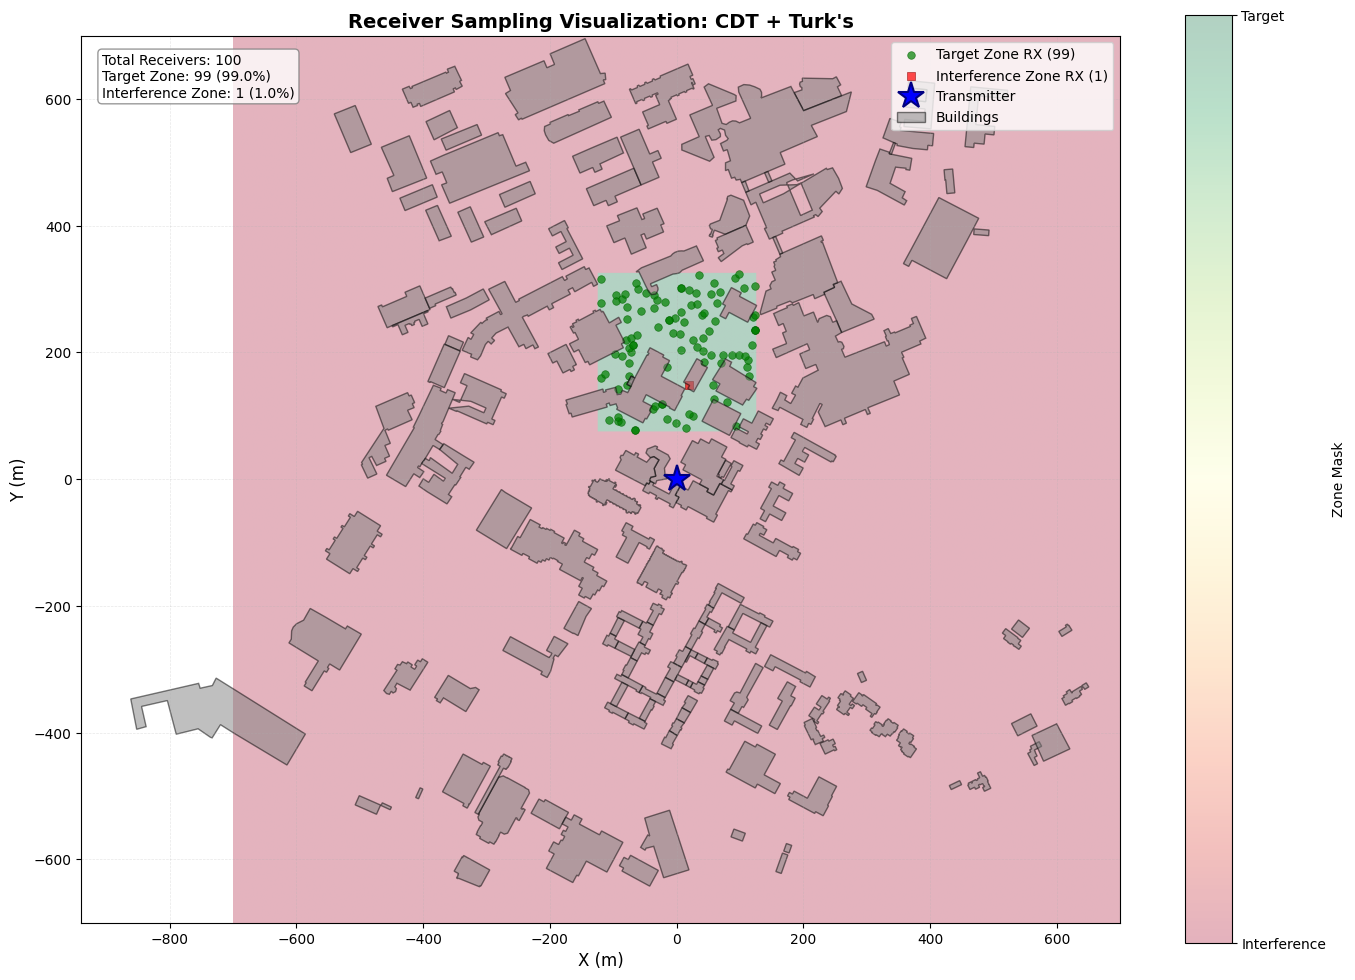

{'center': [0.0, 200.0], 'width': 250, 'height': 250}


/home/shr25/temp/service_aware_geometric_optimization/src/boresight_pathsolver.py:726: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  unit_points = np.array(qrand.random(batch_size))


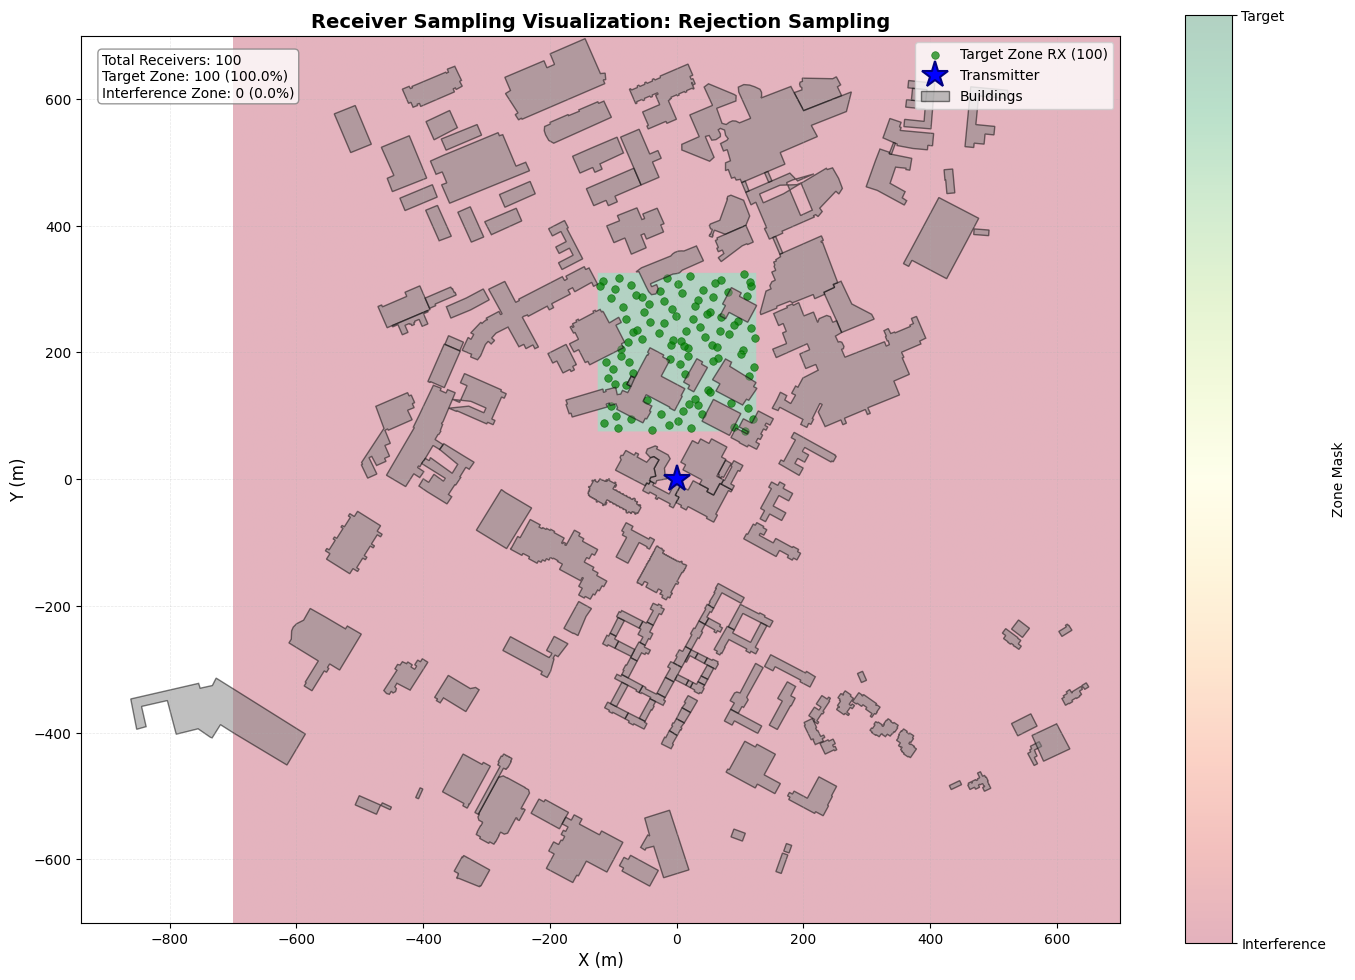

In [7]:
from boresight_pathsolver import visualize_receiver_placement, sample_grid_points
import scipy.stats.qmc as qmc
# Check to see if the discrepancy was maintained (new triangulation functions)
# Visualize the receiver placement to ensure everything looks correct
fig = visualize_receiver_placement(
    sample_points=out,
    zone_mask=zone_mask,
    map_config=map_config,
    tx_position=[0.0,0.0,0.0],
    scene_xml_path=scene_xml_path,
    title="Receiver Sampling Visualization: CDT + Turk's",
    figsize=(14, 10),
)
plt.show()

qrand_op = qmc.Sobol(d=2, scramble=True)
rej_points = sample_grid_points(
            map_config,
            scene_xml_path=scene_xml_path,
            exclude_buildings=True,
            zone_params=zone_params,
            zone_mask=zone_mask,
            qrand=qrand_op,
            num_points=100
        )

fig = visualize_receiver_placement(
    sample_points=rej_points,
    zone_mask=zone_mask,
    map_config=map_config,
    tx_position=[0.0,0.0,0.0],
    scene_xml_path=scene_xml_path,
    title="Receiver Sampling Visualization: Rejection Sampling",
    figsize=(14, 10),
)
plt.show()

#from triangulate import run_comparison
#run_comparison(cleaned_polygon, triangles)

In [8]:
# Run the optimization
print("=" * 70)
print("STARTING BINARY MASK OPTIMIZATION")
print("=" * 70)

# Updated to receive 8 return values (added initial_tx_pos and optimized_tx_pos)
(
    best_angles,
    loss_hist,
    angle_hist,
    grad_hist,
    cov_stats,
    initial_angles,
    initial_tx_pos,      # NEW: Initial transmitter position
    optimized_tx_pos     # NEW: Optimized transmitter position
) = optimize_boresight_pathsolver(
    scene=scene,
    tx_name="gnb",
    map_config=map_config,
    scene_xml_path=scene_xml_path,
    zone_mask=zone_mask,
    zone_params=zone_params,
    num_sample_points=100,
    building_id=selected_building_id,
    learning_rate=1.0,
    num_iterations=100,
    verbose=True,
    lds="Latin",
    sampler="Halton"
)

# Print position optimization results
print(f"\nPosition Optimization Results:")
print(f"  Initial TX Position: {initial_tx_pos}")
print(f"  Optimized TX Position: {optimized_tx_pos}")
#print(f"  Position change (Δx): {optimized_tx_pos[0] - initial_tx_pos[0]:.2f}m")

STARTING BINARY MASK OPTIMIZATION
Transmit Power in dBm: 44.0

Binary Mask Zone Coverage Optimization
Transmit power: 44.00 dBm
Learning rate: 1.0
Iterations: 100
Sample points: 100
Loss type: coverage_maximize
Map config: {'center': [0.0, 0.0, 0.0], 'size': [1400, 1400], 'cell_size': (1.0, 1.0), 'ground_height': 0.0}

TX placement mode: skip (using current position)


Auto-detected zone type: box
Cached 10 building polygons for rejection sampling
Actual sample points after building exclusion: 100
Removing 1 existing receiver(s): ['ue']
Pre-creating 100 receivers...
  Created 100 receivers (will reposition each iteration)
Tx Position: [-23.77073860168457, -24.334800720214844, [12.5]]
look_at_position: [0.0, 200.0, 1.5]

PYTORCH TENSOR INITIALIZATION
PyTorch azimuth tensor initialized to: 83.95°
PyTorch elevation tensor initialized to: -2.79°
PyTorch tx_x tensor initialized to: -23.77m

STEP 1: Position parameters created but NOT being optimized yet
        Testing if passing through @d

[-15.445634841918945, -36.22819519042969, 12.5]
Tx Position: [-15.445634841918945, -36.22819519042969, 12.5]
look_at_position: [0.0, 200.0, 0.0]
Naive baseline angles: Azimuth=86.3°, Elevation=-3.0°
Optimized angles: Azimuth=88.3°, Elevation=-0.7°

Computing RadioMap for Naive Baseline...
  Angles: Azimuth=86.3°, Elevation=-3.0°
Computing RadioMap for Optimized...
  Angles: Azimuth=88.3°, Elevation=-0.7°

COMPARISON SUMMARY
Naive Baseline Mean:  5.91e-09 W
Optimized Mean:       7.34e-09 W
Improvement:          +1.43e-09 W (+24.2%)



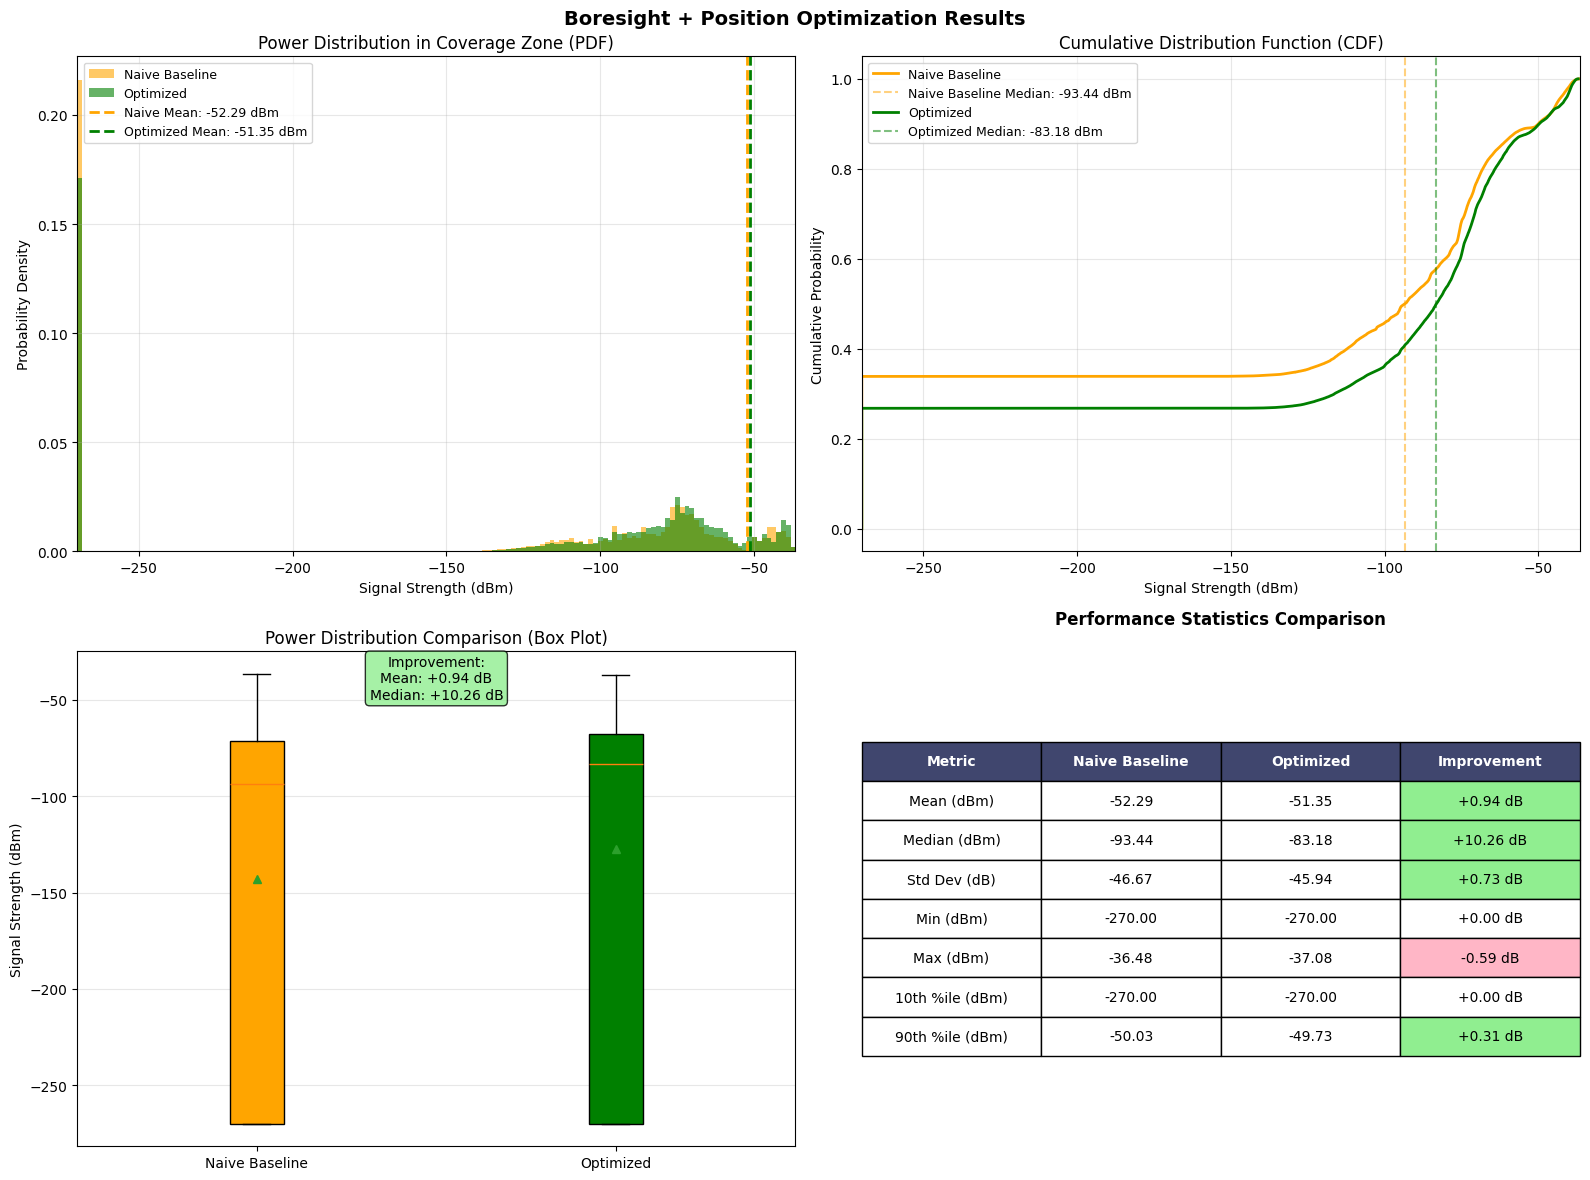

In [9]:
from boresight_pathsolver import compare_boresight_performance
from angle_utils import azimuth_elevation_to_yaw_pitch, compute_initial_angles_from_position
import mitsuba as mi

# Compute naive angles from the naive look_at position
tx = scene.get("gnb")
tx_position = [
    float(tx.position[0][0]),
    float(tx.position[1][0]),
    float(tx.position[2][0])
]
print(tx_position)

# Convert naive look_at position to angles
naive_azimuth, naive_elevation = compute_initial_angles_from_position(
    tx_position, naive_look_at.tolist()
)
naive_angles = [naive_azimuth, naive_elevation]

print(f"Naive baseline angles: Azimuth={naive_azimuth:.1f}°, Elevation={naive_elevation:.1f}°")
print(f"Optimized angles: Azimuth={best_angles[0]:.1f}°, Elevation={best_angles[1]:.1f}°")
print()

# Compare performance using angles AND positions
fig, comparison_stats = compare_boresight_performance(
    scene=scene,
    tx_name="gnb",
    map_config=map_config,
    zone_mask=zone_mask,
    naive_angles=naive_angles,
    optimized_angles=best_angles,
    naive_transmitter_pos=initial_tx_pos,      # NEW: Pass initial position
    optimized_transmitter_pos=optimized_tx_pos,  # NEW: Pass optimized position
    title="Boresight + Position Optimization Results"
)

plt.show()

RADIO MAP VISUALIZATION (OPTIMIZED)
Optimized angles: Azimuth=88.3°, Elevation=-0.7°
TX location: [[-15.4456, -36.2282, 12.5]]
TX orientation (yaw, pitch, roll): (1.541, 0.012, 0.0) rad

Coverage Analysis:
  Mean power in zone: -127.61 dBm
  Median power in zone: -83.18 dBm
  Min power in zone: -270.00 dBm
  Max power in zone: -37.08 dBm
  Std dev in zone: 88.01 dB

  Above -90 dBm: 25454/45131 (56.4%)
  Above -85 dBm: 23474/45131 (52.0%)
  Above -80 dBm: 20952/45131 (46.4%)
  Above -75 dBm: 17621/45131 (39.0%)
  Above -70 dBm: 12780/45131 (28.3%)



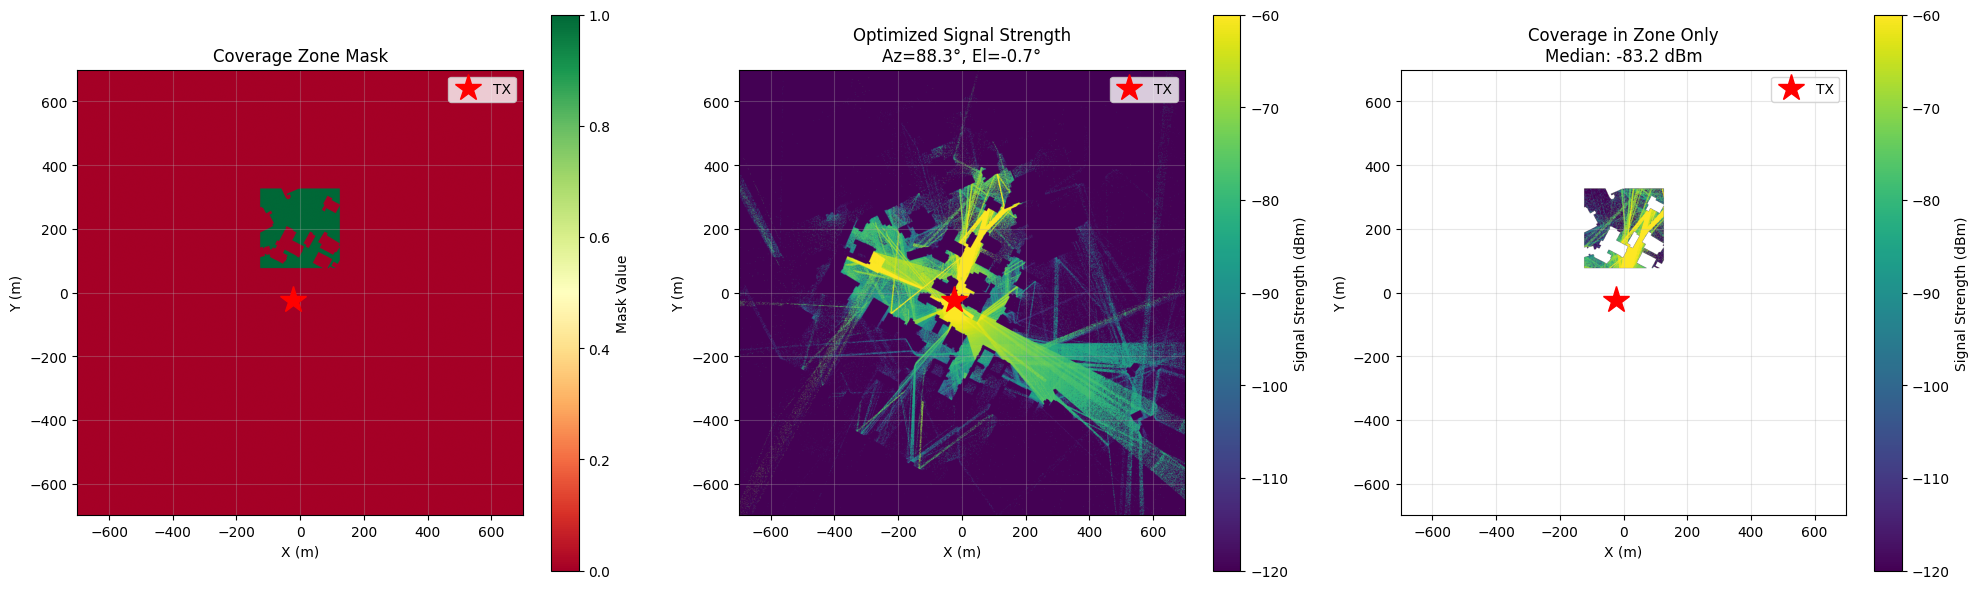

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (101, 2) + inhomogeneous part.

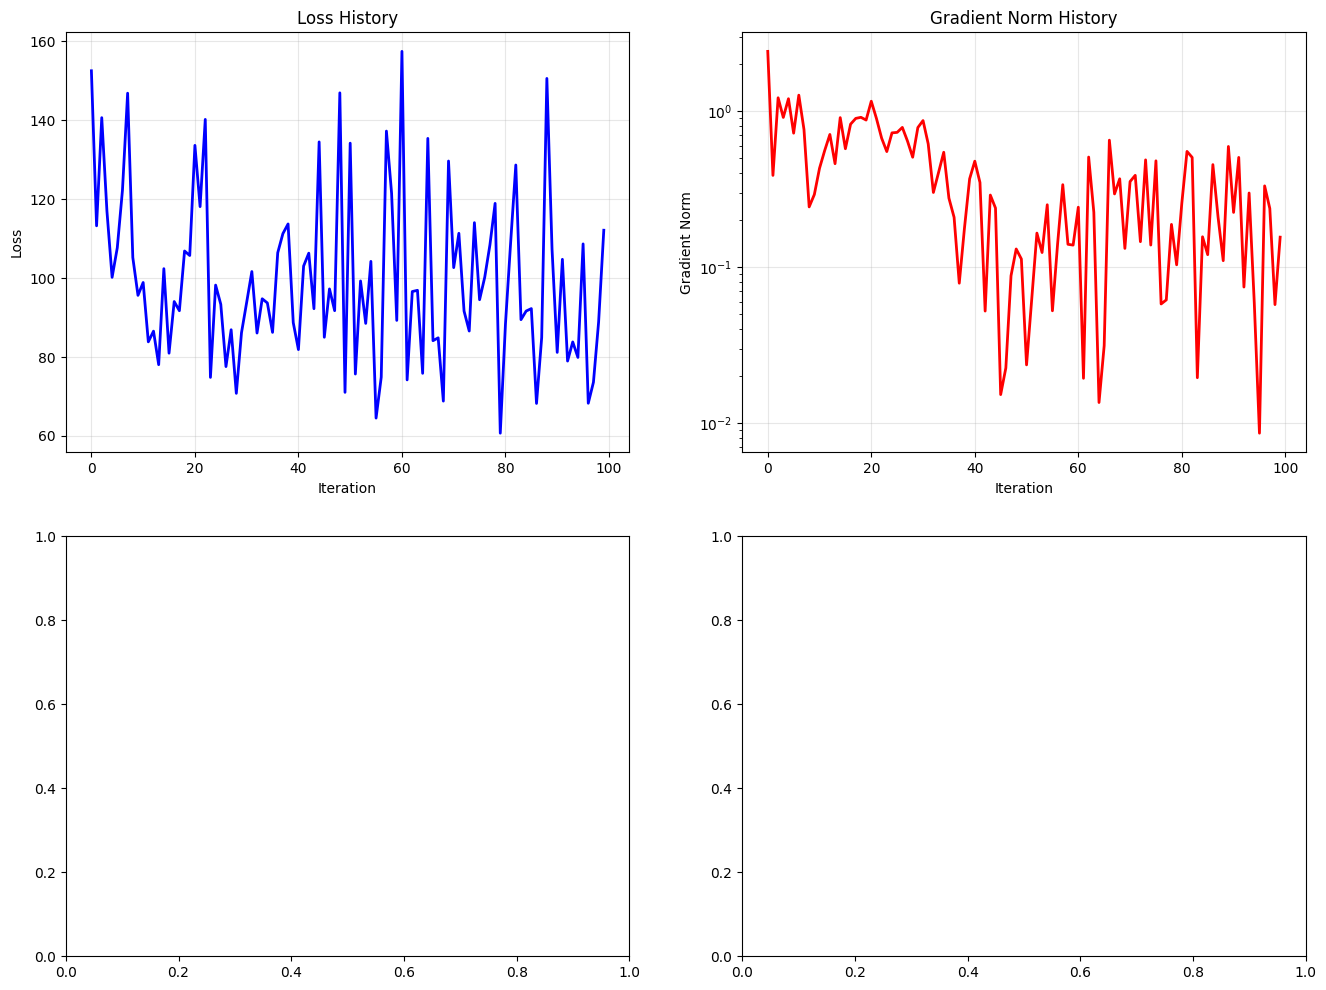

In [10]:
from sionna.rt import RadioMapSolver
from angle_utils import azimuth_elevation_to_yaw_pitch
import matplotlib.pyplot as plt
import mitsuba as mi

# Apply the optimized angles to the transmitter
tx = scene.get("gnb")
best_azimuth, best_elevation = best_angles
yaw_rad, pitch_rad = azimuth_elevation_to_yaw_pitch(best_azimuth, best_elevation)
tx.orientation = mi.Point3f(float(yaw_rad), float(pitch_rad), 0.0)

print("=" * 70)
print("RADIO MAP VISUALIZATION (OPTIMIZED)")
print("=" * 70)
print(f"Optimized angles: Azimuth={best_azimuth:.1f}°, Elevation={best_elevation:.1f}°")
print(f"TX location: {tx.position}")
print(f"TX orientation (yaw, pitch, roll): ({yaw_rad:.3f}, {pitch_rad:.3f}, 0.0) rad")
#print(f"Coverage zone: {cov_stats['num_samples_in_zone']}/{cov_stats['num_samples_total']} samples")
print()

# Generate radio map matching the optimization configuration
rm_solver = RadioMapSolver()
rm = rm_solver(
    scene,
    max_depth=5,
    samples_per_tx=int(6e8),
    cell_size=map_config['cell_size'],
    center=map_config['center'],
    orientation=[0, 0, 0],
    size=map_config['size'],
    los=True,
    specular_reflection=True,
    diffuse_reflection=True,
    refraction=False,
    stop_threshold=None,
)

# Extract signal levels
rss_watts = rm.rss.numpy()[0, :, :]
signal_strength_dBm = 10.0 * np.log10(rss_watts + 1e-30) + 30.0

# ============================================
# Analyze Coverage in the Zone
# ============================================
zone_power = signal_strength_dBm[zone_mask == 1.0]

print("Coverage Analysis:")
print(f"  Mean power in zone: {np.mean(zone_power):.2f} dBm")
print(f"  Median power in zone: {np.median(zone_power):.2f} dBm")
print(f"  Min power in zone: {np.min(zone_power):.2f} dBm")
print(f"  Max power in zone: {np.max(zone_power):.2f} dBm")
print(f"  Std dev in zone: {np.std(zone_power):.2f} dB")
print()

# Count cells above various thresholds
thresholds = [-90, -85, -80, -75, -70]
for thresh in thresholds:
    above = np.sum(zone_power > thresh)
    pct = 100.0 * above / len(zone_power)
    print(f"  Above {thresh} dBm: {above}/{len(zone_power)} ({pct:.1f}%)")
print()

# ============================================
# Visualize Results
# ============================================
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

extent = [
    map_config['center'][0] - map_config['size'][0]/2,
    map_config['center'][0] + map_config['size'][0]/2,
    map_config['center'][1] - map_config['size'][1]/2,
    map_config['center'][1] + map_config['size'][1]/2,
]

# Plot 1: Zone Mask
im1 = axes[0].imshow(zone_mask, origin='lower', cmap='RdYlGn', extent=extent, vmin=0, vmax=1)
axes[0].plot(gnb_position[0], gnb_position[1], 'r*', markersize=20, label='TX')
axes[0].set_title('Coverage Zone Mask')
axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(im1, ax=axes[0], label='Mask Value')

# Plot 2: RadioMap (Signal Strength)
im2 = axes[1].imshow(signal_strength_dBm, origin='lower', cmap='viridis', 
                     extent=extent, vmin=-120, vmax=-60)
axes[1].plot(gnb_position[0], gnb_position[1], 'r*', markersize=20, label='TX')
axes[1].set_title(f'Optimized Signal Strength\nAz={best_azimuth:.1f}°, El={best_elevation:.1f}°')
axes[1].set_xlabel('X (m)')
axes[1].set_ylabel('Y (m)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.colorbar(im2, ax=axes[1], label='Signal Strength (dBm)')

# Plot 3: Masked Coverage (only show zone)
masked_signal = np.where(zone_mask == 1.0, signal_strength_dBm, np.nan)
im3 = axes[2].imshow(masked_signal, origin='lower', cmap='viridis',
                     extent=extent, vmin=-120, vmax=-60)
axes[2].plot(gnb_position[0], gnb_position[1], 'r*', markersize=20, label='TX')
axes[2].set_title(f'Coverage in Zone Only\nMedian: {np.median(zone_power):.1f} dBm')
axes[2].set_xlabel('X (m)')
axes[2].set_ylabel('Y (m)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
plt.colorbar(im3, ax=axes[2], label='Signal Strength (dBm)')

plt.tight_layout()
plt.show()

# ============================================
# Optimization Diagnostics - UPDATED for Angles
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss history
axes[0, 0].plot(loss_hist, 'b-', linewidth=2)
axes[0, 0].set_title('Loss History')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# Gradient norms
axes[0, 1].plot(grad_hist, 'r-', linewidth=2)
axes[0, 1].set_title('Gradient Norm History')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Gradient Norm')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# Angle trajectory - Azimuth
angle_arr = np.array(angle_hist)
axes[1, 0].plot(angle_arr[:, 0], 'g-', linewidth=2, label='Azimuth')
axes[1, 0].axhline(y=best_azimuth, color='b', linestyle='--', label=f'Final: {best_azimuth:.1f}°')
axes[1, 0].set_title('Azimuth Angle Optimization')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Azimuth (degrees)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Angle trajectory - Elevation
axes[1, 1].plot(angle_arr[:, 1], 'm-', linewidth=2, label='Elevation')
axes[1, 1].axhline(y=best_elevation, color='b', linestyle='--', label=f'Final: {best_elevation:.1f}°')
axes[1, 1].set_title('Elevation Angle Optimization')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Elevation (degrees)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()